# International Stock Market Visualization

In [1]:
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta, FR

from bokeh.plotting import figure, show
from bokeh.models import TickFormatter, MultiSelect, CustomJS, ColumnDataSource, HoverTool
from bokeh.layouts import row
from bokeh.palettes import Category10, Category20, Category20b, Category20c
from bokeh.util.compiler import TypeScript
from bokeh.io import output_notebook
output_notebook()

import pandas as pd
pd.set_option('display.max_rows', 100) 

import os
import numpy as np
import sqlite3 as sl
from sqlite3 import Error

import time
import json
import csv
from io import StringIO
import matplotlib.pyplot as plt

import requests
from requests.structures import CaseInsensitiveDict
import urllib.parse

import quandl
secrets = json.load(open("secrets.json", "r"))
quandl.ApiConfig.api_key = secrets["nasdaq-quandl"]["api-key"]


Loading BokehJS ...

## Create database if not exists
To avoid too much queries and unnecessary data updates, we create/load a database.
We define that we are only interested in the data until last Friday.

In [2]:
start_date = datetime(2010, 1, 1)
last_date = start_date
date_of_last_friday = datetime.now() + relativedelta(weekday=FR(-1))
print("last friday is", date_of_last_friday.isoformat(timespec='milliseconds'))

db_abs_path = os.path.abspath('international_data.db')
db_conn = sl.connect(db_abs_path)

# create table 'currency' if not exists
db_conn.execute("""create table if not exists currency 
            (date DATE, USD_EUR REAL, USD_CNY REAL, USD_JPY REAL, USD_GBP REAL,
            PRIMARY KEY (date))""")

# create table 'commodity' if not exists
db_conn.execute("""create table if not exists commodity 
            (date DATE, OIL REAL, GOLD REAL, SILVER REAL,
            PRIMARY KEY (date))""")

# create table 'bop' if not exists
db_conn.execute("""create table if not exists bop 
            (date DATE, COUNTRY nvarchar(100), IMPORT FLOAT, EXPORT FLOAT, TOTAL FLOAT,
            PRIMARY KEY (date))""")

last friday is 2023-07-14T12:23:26.609


## History of Currency Exchange Rates
Exchange rates until last Friday.
https://app.freecurrencyapi.com/request-playground

In [3]:
currency_df = pd.read_sql_query("SELECT * FROM currency", db_conn)
if len(currency_df.index)>0:
    dates = pd.to_datetime(currency_df['date'])
    last_date = dates.max()

if last_date < date_of_last_friday:
    api_key = secrets["freecurrencyapi"]["api-key"]

    delta_in_s = (date_of_last_friday - last_date).total_seconds()
    years = int(divmod(delta_in_s, 31536000)[0])

    if years > 0:
        print(f"delta is too large: {years}. we split the timeslot to years.")
        for i in range(years):
            url = f"https://api.freecurrencyapi.com/v1/historical?apikey={api_key}&currencies=EUR%2CCNY%2CJPY%2CGBP&"+ \
            f"date_from={urllib.parse.quote((last_date + relativedelta(years=i)).isoformat(timespec='milliseconds'))}Z&"+ \
            f"date_to={urllib.parse.quote((last_date + relativedelta(years=i+1)).isoformat(timespec='milliseconds'))}Z"

            resp = requests.get(url)
            if resp.status_code == 200:
                data = json.loads(resp.content)["data"]
                
                for key, value in data.items():
                    row = pd.DataFrame({'date': [key], 'USD_EUR': [value["EUR"]], "USD_CNY": [value["CNY"]], "USD_JPY": [value["JPY"]], "USD_GBP": [value["GBP"]]})
                    currency_df = pd.concat([currency_df, row], ignore_index=True)
        last_date = last_date + relativedelta(years=years)
    
    url = f"https://api.freecurrencyapi.com/v1/historical?apikey={api_key}&currencies=EUR%2CCNY%2CJPY%2CGBP&"+\
        f"date_from={urllib.parse.quote(last_date.isoformat(timespec='milliseconds'))}Z&date_to={urllib.parse.quote(date_of_last_friday.isoformat(timespec='milliseconds'))}Z"
    print(url)
    resp = requests.get(url)
    if resp.status_code == 200:
        print("success")
        data = json.loads(resp.content)["data"]
        
        for key, value in data.items():
            row = pd.DataFrame({'date': [key], 'USD_EUR': [value["EUR"]], "USD_CNY": [value["CNY"]], "USD_JPY": [value["JPY"]], "USD_GBP": [value["GBP"]]})
            currency_df = pd.concat([currency_df, row], ignore_index=True)
        
        print(currency_df.head(5))
        currency_df.to_sql('currency', db_conn, if_exists='replace',index=False)
    else:
        print("failure with status code:", resp.status_code, resp.content)


https://api.freecurrencyapi.com/v1/historical?apikey=ctRZcHxbmXYjzUQO2pqDnhBJAlb8VfgpoKwQlwZq&currencies=EUR%2CCNY%2CJPY%2CGBP&date_from=2023-05-26T00%3A00%3A00.000Z&date_to=2023-07-14T12%3A23%3A26.609Z
success
         date  USD_EUR  USD_CNY   USD_JPY  USD_GBP
0  2010-01-01  0.69727  6.82893  92.91181  0.61823
1  2010-01-02  0.69610  6.82894  92.74270  0.61788
2  2010-01-03  0.69609  6.82893  92.74301  0.61788
3  2010-01-04  0.69393  6.82821  92.64924  0.62049
4  2010-01-05  0.69495  6.82764  91.66565  0.62449


We check development of international currency market.

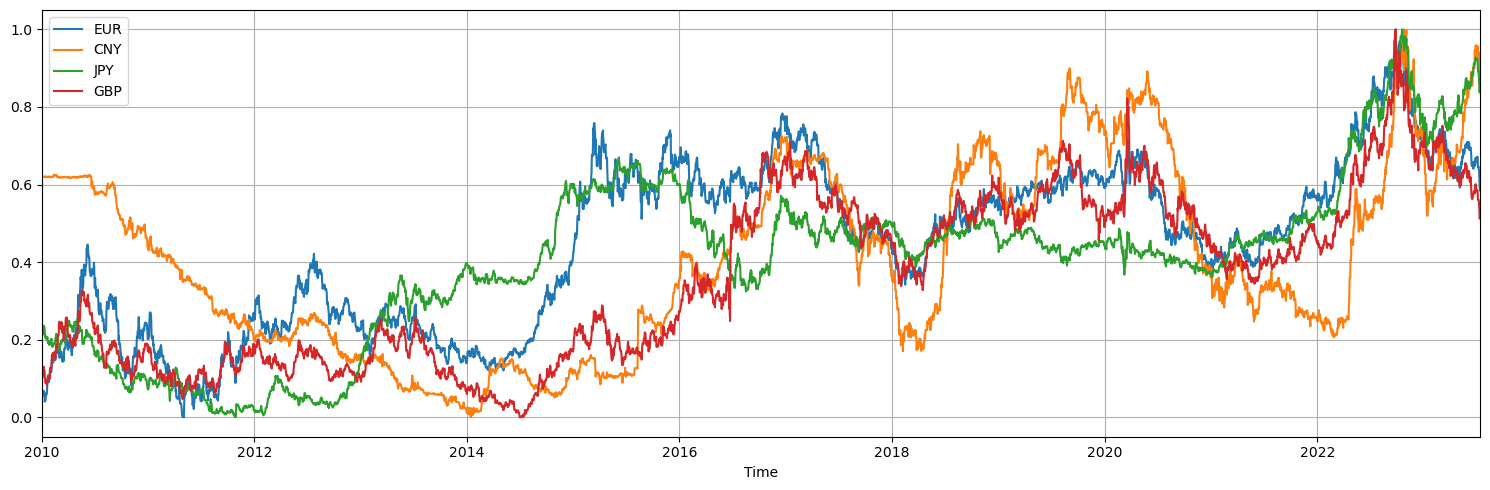

In [4]:
currency_df["date"] = pd.to_datetime(currency_df["date"])

fig, ax = plt.subplots(figsize=(15,5))

for cur in ['EUR', 'CNY', 'JPY', 'GBP']:
    raw_data = currency_df['USD_'+cur]
    normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
    ax.plot(currency_df['date'], normalized, label=cur)

ax.set_xlabel('Time')
plt.xlim(currency_df['date'].min(), currency_df['date'].max())
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

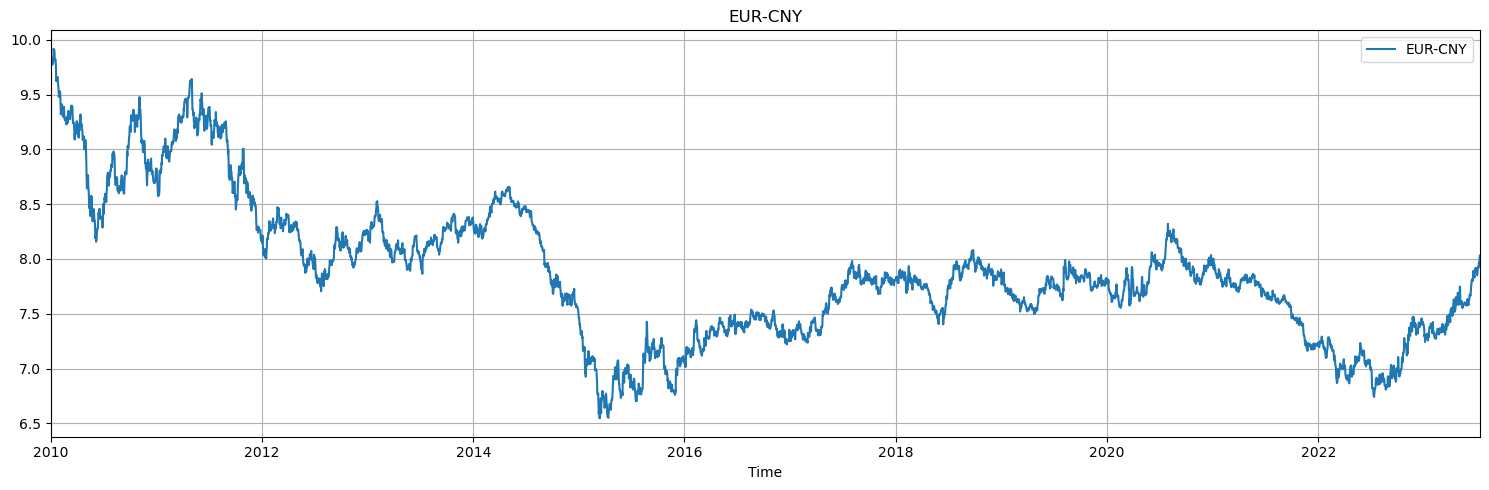

In [5]:
fig, ax = plt.subplots(figsize=(15,5))

raw_data = currency_df['USD_CNY'] / currency_df['USD_EUR'] 
ax.plot(currency_df['date'], raw_data, label="EUR-CNY")

ax.set_xlabel('Time')
plt.xlim(currency_df['date'].min(), currency_df['date'].max())
plt.legend()
plt.grid()
plt.title("EUR-CNY")
plt.tight_layout()
plt.show()

## Commodity and Futures Prices
- [OPEC Crude Oil Price](https://data.nasdaq.com/data/OPEC-organization-of-the-petroleum-exporting-countries)
- [Gold Price: London Fixing](https://data.nasdaq.com/data/LBMA/GOLD-gold-price-london-fixing)
- [Silver Price: London Fixing](https://data.nasdaq.com/data/LBMA/SILVER-silver-price-london-fixing)

In [6]:
last_date = start_date
# commodity_df = pd.read_sql_query("SELECT * FROM commodity", db_conn)
# if len(commodity_df.index)>0:
#     dates = pd.to_datetime(currency_df['date'])
#     last_date = dates.max()
    
# get oil price
df = quandl.get('OPEC/ORB', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d")).reset_index()
result_df = df.rename(columns={"Value": "OIL", "Date":"date"})

# get gold price
df = quandl.get('LBMA/GOLD', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d")).reset_index()
# df.index.names=["date"]
result_df = result_df.join(df[["USD (PM)"]].rename(columns={"USD (PM)": "GOLD", "Date":"date"}))

# get silver price
df = quandl.get('LBMA/SILVER', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d")).reset_index()
result_df = result_df.join(df[["USD"]].rename(columns={"USD": "SILVER", "Date":"date"}))

commodity_df = result_df
commodity_df.to_sql('commodity', db_conn, if_exists='replace',index=False)
commodity_df.head(5)


,date,OIL,GOLD,SILVER
0,2010-01-04,78.23,1121.50,17.17
1,2010-01-05,79.14,1123.25,17.57
2,2010-01-06,79.70,1130.00,17.89
3,2010-01-07,80.19,1130.25,18.09
4,2010-01-08,79.94,1126.75,18.12


        date    OIL     GOLD  SILVER
0 2010-01-04  78.23  1121.50   17.17
1 2010-01-05  79.14  1123.25   17.57
2 2010-01-06  79.70  1130.00   17.89
3 2010-01-07  80.19  1130.25   18.09
4 2010-01-08  79.94  1126.75   18.12


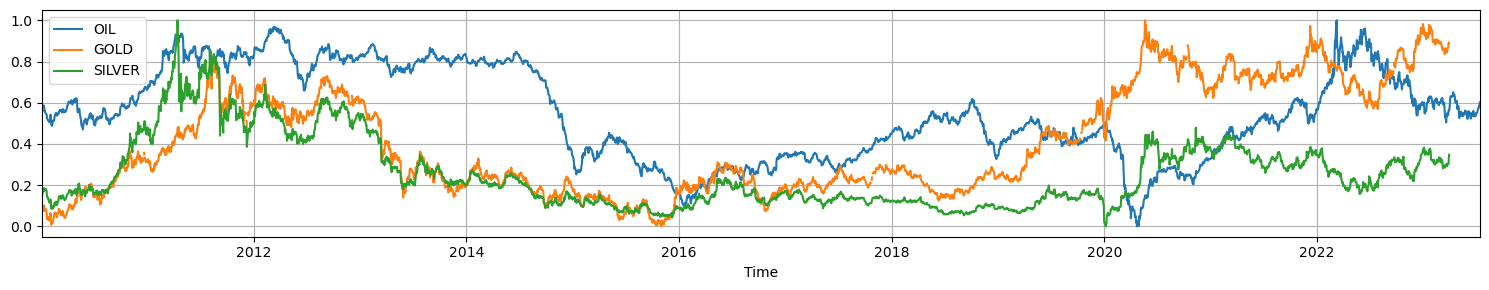

In [7]:
print(commodity_df.head(5))
commodity_df["date"] = pd.to_datetime(commodity_df["date"])

fig, ax = plt.subplots(figsize=(15,3))
for comm in ['OIL', 'GOLD', 'SILVER']:
    raw_data = commodity_df[comm]
    normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
    ax.plot(commodity_df["date"], normalized, label=comm)

ax.set_xlabel('Time')
plt.xlim(commodity_df["date"].min(), commodity_df["date"].max())
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Interest Rates
- United States: Nasdaq / U.S. Treasury [link](https://data.nasdaq.com/data/USTREASURY-us-treasury?utm_campaign=&utm_content=api-for-interest-rate-data&utm_medium=organic&utm_source=google)
- European: Deutsche Bundesbank / European Central Bank [link](https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/ecb-interest-rates-626986)

In [8]:
# api_url = 'https://api.api-ninjas.com/v1/interestrate'
# response = requests.get(api_url, headers={'X-Api-Key': secrets["ninjas-api"]["api-key"]})
# if response.status_code == requests.codes.ok:
#     print(response.text)
# else:
#     print("Error:", response.status_code, response.text)

In [9]:
# get US treasury rates
df = quandl.get("USTREASURY/BILLRATES", start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d")).reset_index()
df = df[["Date", "4 Wk Bank Discount Rate", "13 Wk Bank Discount Rate", "26 Wk Bank Discount Rate"]] \
    .rename(columns={"4 Wk Bank Discount Rate": "US_1month", "13 Wk Bank Discount Rate":"US_1year", "26 Wk Bank Discount Rate":"US_2years","Date":"date"})

# get European interest rates
response = requests.get("https://api.statistiken.bundesbank.de/rest/download/BBK01/SU0200?format=csv&lang=en")
if response.status_code == requests.codes.ok:
    euro_df = pd.read_csv(StringIO(response.text))
    euro_df.columns =['date', 'EURO', 'Others']
    euro_df.drop(columns=['Others'], inplace=True)
    euro_df['date'] = pd.to_datetime(euro_df['date'], format='%Y-%m-%d', errors='coerce')
    euro_df = euro_df[euro_df['date'].between(last_date.strftime("%Y-%m-%d"), date_of_last_friday.strftime("%Y-%m-%d"))]
    euro_df['EURO'] = euro_df['EURO'].astype('float32')
    df = df.join(euro_df.set_index('date'), how="inner", on="date")
else:
    print("Error:", response.status_code, response.text)

print(df.tail(5))

           date  US_1month  US_1year  US_2years  EURO
3232 2022-12-01       3.87      4.22       4.49  2.00
3273 2023-02-01       4.46      4.54       4.65  2.50
3292 2023-03-01       4.52      4.73       4.96  3.00
3335 2023-05-01       4.32      5.10       4.91  3.25
3357 2023-06-01       5.14      5.24       5.21  3.50


## Balance of Payment between China and EU
- http://data.mofcom.gov.cn/hwmy/imexCountry.shtml

In [10]:
bop_df = pd.read_sql_query("SELECT * FROM bop", db_conn, index_col=None)
datatype = bop_df.dtypes

last_date = datetime(2020, 1, 1)
if len(bop_df.index)>0:
    dates = pd.to_datetime(bop_df['date'])
    last_date = dates.max()

print("last_date:", last_date, "date_of_last_friday", date_of_last_friday)
while True:
    if last_date <= date_of_last_friday:
        time.sleep(50.0/1000)
        r = requests.post("http://data.mofcom.gov.cn/datamofcom/front/totalbycountry/query", 
                        {"date":last_date.strftime("%Y%m")},
                    headers={"Content-Length":"11", "Connection":"keep-alive", 
                                "X-Requested-With":"XMLHttpRequest", 
                                "Content-Type":"application/x-www-form-urlencoded; charset=UTF-8",
                                "Accept-Encoding":"gzip, deflate",
                                "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0",
                                "Origin": "http://data.mofcom.gov.cn",
                                "Referer":"http://data.mofcom.gov.cn/hwmy/imexCountry.shtml"})
        
        if r.status_code == requests.codes.ok:
            data = json.loads(r.content)["rows"]
            for item in data:
                if item["type"] in ["德国","法国","意大利","荷兰", "西班牙","瑞士"]:
                    row = pd.DataFrame({'date': [pd.to_datetime(item["trade_date"], format="%Y%m").date()], 
                                        'COUNTRY': [item["type"]], 
                                        "IMPORT": [float(item["import_lj_value"])], 
                                        "EXPORT": [float(item["export_lj_value"])], 
                                        "TOTAL": [float(item["total_lj_value"])]})
                    bop_df = pd.concat([bop_df, row], ignore_index=True)
            last_date = last_date + relativedelta(months=1)
        else:
            print("Error:", r.status_code, r.text)
            break
    else:
        break

print(bop_df.tail(10))
db_conn.execute("""delete from bop""")
bop_df.to_sql(name='bop', con=db_conn, if_exists='replace', index=False)
bop_df["date"] = pd.to_datetime(bop_df["date"])

last_date: 2023-04-01 00:00:00 date_of_last_friday 2023-07-14 12:23:26.609795
           date COUNTRY  IMPORT  EXPORT   TOTAL
278  2023-04-01     意大利   87.53  148.79  236.32
279  2023-04-01      荷兰   43.06  349.50  392.56
280  2023-04-01     西班牙   30.85  131.62  162.47
281  2023-04-01      瑞士  204.72   19.53  224.26
282  2023-05-01      德国  445.61  432.03  877.64
283  2023-05-01      法国  158.87  172.56  331.43
284  2023-05-01     意大利  111.81  191.10  302.91
285  2023-05-01      荷兰   55.28  438.90  494.18
286  2023-05-01     西班牙   39.49  165.92  205.40
287  2023-05-01      瑞士  262.14   24.32  286.46


In [11]:
euro_monthly_bof = bop_df.groupby(by="date").sum(numeric_only=True)
euro_monthly_bof.index = pd.to_datetime(euro_monthly_bof.index)
euro_monthly_bof.sort_index(inplace=True)
euro_monthly_bof["DIFF"] = euro_monthly_bof["IMPORT"]-euro_monthly_bof["EXPORT"]

euro_monthly_bof.tail(10)

,IMPORT,EXPORT,TOTAL,DIFF
date,,,,
2022-08-01,1620.80,2595.65,4216.45,-974.85
2022-09-01,1828.15,2906.26,4734.40,-1078.11
2022-10-01,2028.03,3204.51,5232.54,-1176.48
2022-11-01,2234.08,3504.76,5738.85,-1270.68
2022-12-01,2459.34,3798.98,6258.32,-1339.64
2023-01-01,176.62,311.16,487.80,-134.54
2023-02-01,384.38,531.28,915.68,-146.90
2023-03-01,632.02,832.89,1464.91,-200.87
2023-04-01,6730.24,9042.64,15773.04,-2312.40


In [12]:
euro_monthly_bof_diff = euro_monthly_bof.diff()
cols = list(euro_monthly_bof_diff.columns)
jan_data = euro_monthly_bof[euro_monthly_bof.index.month == 1]
euro_monthly_bof_diff.loc[euro_monthly_bof_diff.index.isin(jan_data.index), cols] = jan_data[cols]
# euro_monthly_bof_diff = euro_monthly_bof_diff.merge(, on="date", how="outer")

euro_monthly_bof_diff.tail(10)

,IMPORT,EXPORT,TOTAL,DIFF
date,,,,
2022-08-01,233.74,344.33,578.08,-110.59
2022-09-01,207.35,310.61,517.95,-103.26
2022-10-01,199.88,298.25,498.14,-98.37
2022-11-01,206.05,300.25,506.31,-94.20
2022-12-01,225.26,294.22,519.47,-68.96
2023-01-01,176.62,311.16,487.80,-134.54
2023-02-01,207.76,220.12,427.88,-12.36
2023-03-01,247.64,301.61,549.23,-53.97
2023-04-01,6098.22,8209.75,14308.13,-2111.53


2023-07-14T00:00:00.000000000 8.031389825956573


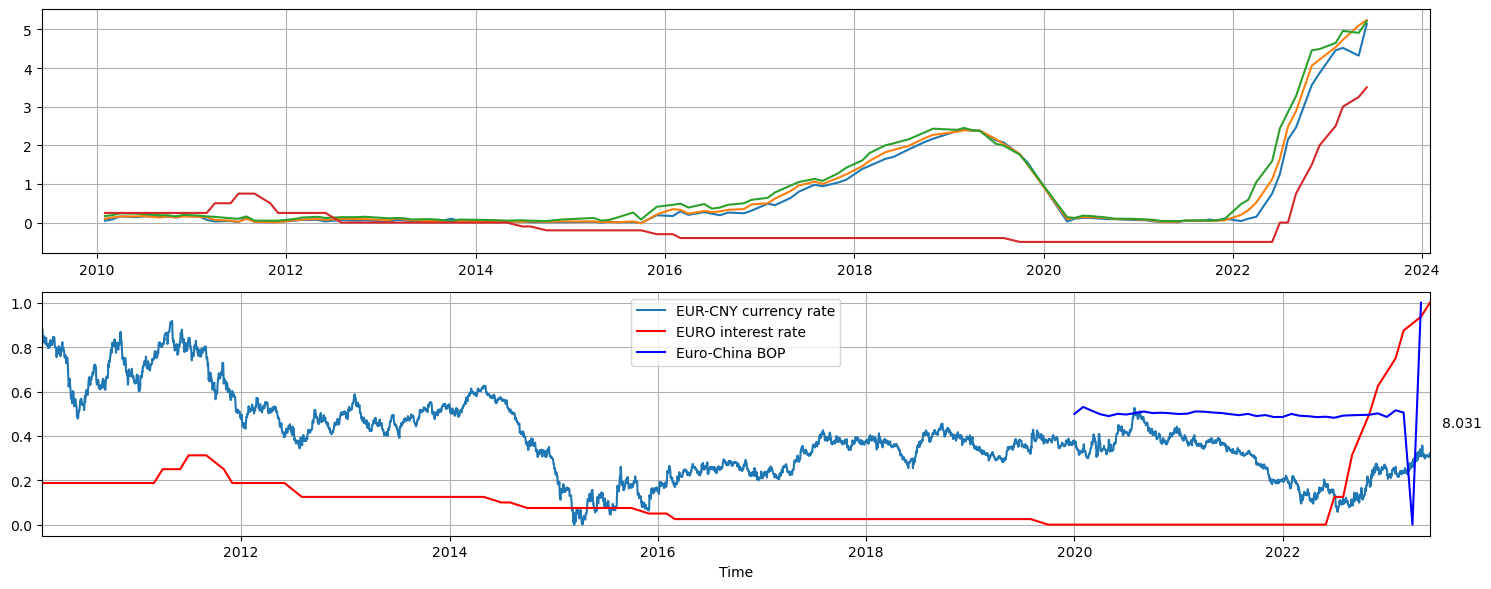

In [13]:
# draw the development of interest rates for Europa, US
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
with_normalization = False
for comm in ['US_1month', 'US_1year', 'US_2years', 'EURO']:
    raw_data = df[comm]
    if with_normalization:
        normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
        ax[0].plot(df["date"], normalized, label=comm)
        ax[0].text(df["date"][-1], normalized[-1], str(normalized[-1]))
    else:
        ax[0].plot(df["date"], raw_data, label=comm)
        # ax[0].text(df["date"][-1], raw_data[-1], str(raw_data[-1]))

# compare interest and currency rates
raw_data = currency_df['USD_CNY'] / currency_df['USD_EUR']
print(currency_df['date'].values[-1], raw_data.values[-1])

normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
ax[1].plot(currency_df['date'], normalized, label="EUR-CNY currency rate")
ax[1].text(currency_df['date'].values[-1], normalized.values[-1], "{:.3f}".format(raw_data.values[-1]))

raw_data = df['EURO']
normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
ax[1].plot(df["date"], normalized, label='EURO interest rate', c="r")


normalized = (euro_monthly_bof_diff['DIFF'] - euro_monthly_bof_diff['DIFF'].min())/(euro_monthly_bof_diff['DIFF'].max() - euro_monthly_bof_diff['DIFF'].min())
ax[1].plot(euro_monthly_bof.index, normalized, label='Euro-China BOP', c="b")

# ax[1].text(df["date"][-1], normalized.values[-1], "{:.3f}".format(raw_data.values[-1]))

plt.xlabel('Time')
plt.xlim(df["date"].min(), df["date"].max())
plt.legend()
plt.tight_layout()
ax[0].grid()
ax[1].grid()
plt.show()

## Explore stock markets and record symbols for further steps
Get all symbols by countries, indices, industries

In [14]:
from pytickersymbols import PyTickerSymbols

stock_data = PyTickerSymbols()
countries = stock_data.get_all_countries()
indices = stock_data.get_all_indices()
industries = stock_data.get_all_industries()

de_dax_stocks = stock_data.get_stocks_by_index('DAX')
uk_ftse_stocks = stock_data.get_stocks_by_index('FTSE 100')

stock_data.get_all_stocks()[0]

{'name': 'adidas AG',
 'symbol': 'ADS',
 'country': 'Germany',
 'indices': ['DAX', 'EURO STOXX 50'],
 'industries': ['Cyclical Consumer Products',
  'Footwear',
  'Textiles & Apparel',
  'Consumer Cyclicals',
  'Sportswear',
  'Toiletries'],
 'symbols': [{'yahoo': 'ADS.F', 'google': 'FRA:ADS', 'currency': 'EUR'},
  {'yahoo': 'ADDDF', 'google': 'OTCMKTS:ADDDF', 'currency': 'USD'},
  {'yahoo': 'ADDYY', 'google': 'OTCMKTS:ADDYY', 'currency': 'USD'},
  {'yahoo': 'ADS1.F', 'google': 'FRA:ADS1', 'currency': 'EUR'}],
 'metadata': {'founded': 1924, 'employees': 57016},
 'isins': ['DE000A1EWWW0'],
 'akas': []}

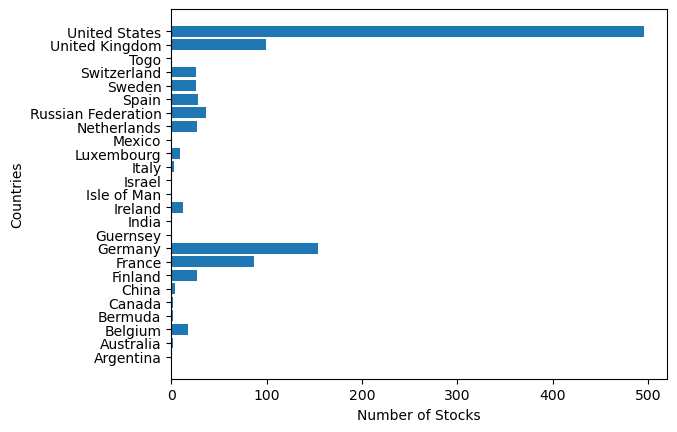

In [15]:
stock_info_df = pd.read_json(json.dumps(stock_data.get_all_stocks()))
stock_info_df.drop(['wiki_name', 'akas'], inplace=True, axis=1)     # remove unused columns
df = stock_info_df.groupby(['country'])['country'].count().reset_index(name="count")

fig, ax = plt.subplots()
y_pos = np.arange(len(df["country"]))
ax.barh(y_pos, df["count"])
ax.set_xlabel('Number of Stocks')
ax.set_yticks(y_pos, labels=df["country"])
ax.set_ylabel('Countries')
plt.show()

Extract all yahoo tickers

In [16]:
yahoo_tickers = stock_info_df.assign(ticker=lambda x: x['symbols'])

# remove stock with empty symbol
yahoo_tickers = yahoo_tickers.drop(yahoo_tickers[yahoo_tickers["ticker"].apply(lambda x: len(x))==0].index)
# extract yahoo symbol
yahoo_tickers["ticker"] = yahoo_tickers["ticker"].apply(lambda x: x[0]['yahoo'])
yahoo_tickers.head(5)

,name,symbol,country,indices,industries,symbols,metadata,isins,ticker
0,adidas AG,ADS,Germany,"[DAX, EURO STOXX 50]","[Cyclical Consumer Products, Footwear, Textile...","[{'yahoo': 'ADS.F', 'google': 'FRA:ADS', 'curr...","{'founded': 1924, 'employees': 57016}",[DE000A1EWWW0],ADS.F
1,Allianz SE,ALV,Germany,"[DAX, EURO STOXX 50]","[Insurance, Financials, Multiline Insurance & ...","[{'yahoo': 'ALV.F', 'google': 'FRA:ALV', 'curr...","{'founded': 1890, 'employees': 147268}",[DE0008404005],ALV.F
2,BASF SE,BAS,Germany,"[DAX, EURO STOXX 50]","[Diversified Chemicals, Basic Materials, Chemi...","[{'yahoo': 'BAS.F', 'google': 'FRA:BAS', 'curr...","{'founded': 1865, 'employees': 117628}",[DE000BASF111],BAS.F
3,Bayer AG,BAYN,Germany,"[DAX, EURO STOXX 50]","[Pharmaceuticals, Pharmaceuticals & Medical Re...","[{'yahoo': 'BAYN.F', 'google': 'FRA:BAYN', 'cu...","{'founded': 1863, 'employees': 103824}",[DE000BAY0017],BAYN.F
4,Beiersdorf AG,BEI,Germany,[DAX],"[Consumer Non-Cyclicals, Personal Products, Pe...","[{'yahoo': 'BEI.F', 'google': 'FRA:BEI', 'curr...","{'founded': 1882, 'employees': 20306}",[DE0005200000],BEI.F


Parse industry and stock list

In [17]:
import yfinance as yf

msft = yf.Ticker("SMEGF") # MSFT, SMEGF
msft.info

HTTPError: 401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SMEGF?modules=summaryProfile%2CfinancialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&ssl=true

Release all resources

## Prepare Training Data
The training data includes:
- currency rates
- commodity / futures prices
- interest rates
- stock prices

In [ ]:
window_size = 30    # window_size = 30 days
train_data.rolling(window_size)

In [ ]:
db_conn.close()